**Application to image denoising:**

Train the autoencoder to map noisy digits images to clean digits images.
Here generating the synthetic noisy digits: by appling a gaussian noise matrix and clip the images between 0 and 1.



In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11493376/11490434 [==============================] - 0s 0us/step


Noisy digits


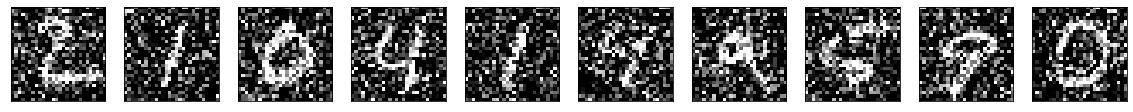

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(20, 2))
print("Noisy digits")
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, using a slightly different model with more filters per layer.

In [6]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 32)        0     

In [10]:
autoencoder_train = autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                verbose = 1,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
469/469 [==============================] - 146s 311ms/step - loss: 0.1161 - val_loss: 0.1110
Epoch 2/10
469/469 [==============================] - 146s 311ms/step - loss: 0.1092 - val_loss: 0.1061
Epoch 3/10
469/469 [==============================] - 146s 312ms/step - loss: 0.1058 - val_loss: 0.1035
Epoch 4/10
469/469 [==============================] - 146s 311ms/step - loss: 0.1036 - val_loss: 0.1017
Epoch 5/10
469/469 [==============================] - 146s 312ms/step - loss: 0.1021 - val_loss: 0.1007
Epoch 6/10
469/469 [==============================] - 147s 314ms/step - loss: 0.1009 - val_loss: 0.0994
Epoch 7/10
469/469 [==============================] - 146s 312ms/step - loss: 0.1001 - val_loss: 0.0990
Epoch 8/10
469/469 [==============================] - 147s 313ms/step - loss: 0.0994 - val_loss: 0.0982
Epoch 9/10
469/469 [==============================] - 146s 311ms/step - loss: 0.0988 - val_loss: 0.0977
Epoch 10/10
469/469 [==============================] - 145s 310m

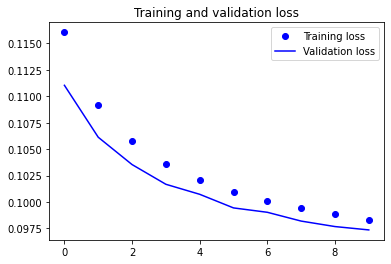

In [11]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(10)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test_noisy)
decoded_imgs = autoencoder.predict(x_test)

Top, the noisy digits fed to the network, and bottom, the digits are reconstructed by the network.



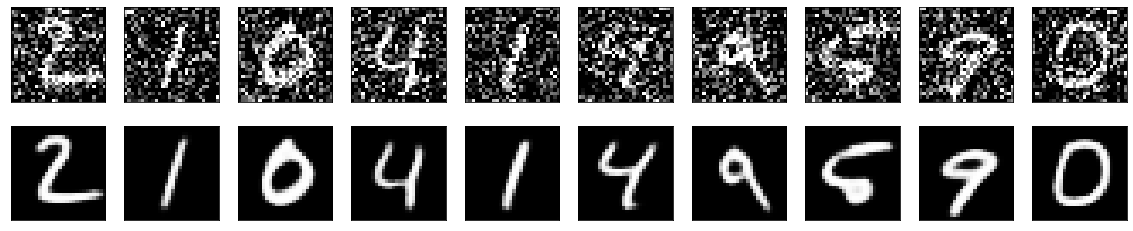

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

***Sequence-to-sequence autoencoder***

If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

***Variational Autoencoder (VAE):***

It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data.VAE is a "generative model".

In [26]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [27]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [28]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [29]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [32]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae_train = vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/50
1875/1875 [==============================] - 6s 3ms/step - loss: 149.2254 - val_loss: 149.8327
Epoch 2/50
1875/1875 [==============================] - 6s 3ms/step - loss: 149.0499 - val_loss: 150.0585
Epoch 3/50
1875/1875 [==============================] - 6s 3ms/step - loss: 148.9185 - val_loss: 149.7188
Epoch 4/50
1875/1875 [==============================] - 6s 3ms/step - loss: 148.7739 - val_loss: 149.5370
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 148.6443 - val_loss: 149.6189
Epoch 6/50
1875/1875 [==============================] - 6s 3ms/step - loss: 148.4957 - val_loss: 149.3119
Epoch 7/50
1875/1875 [==============================] - 6s 3ms/step - loss: 148.3904 - val_loss: 149.4084
Epoch 8/50
1875/1875 [==============================] - 6s 3ms/step - loss: 148.2674 - val_loss: 149.3396
Epoch 9/50
1875/1875 [==============================] - 6s 3ms/step - loss: 148.1603 - val_loss: 149.1878
Epoch 10/50
1875/1875 [=======================

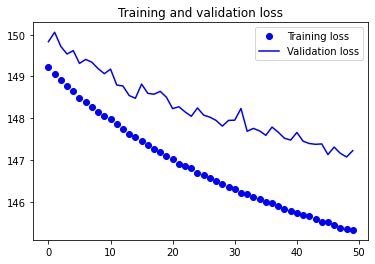

In [33]:
loss = vae_train.history['loss']
val_loss = vae_train.history['val_loss']
epochs = range(50)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

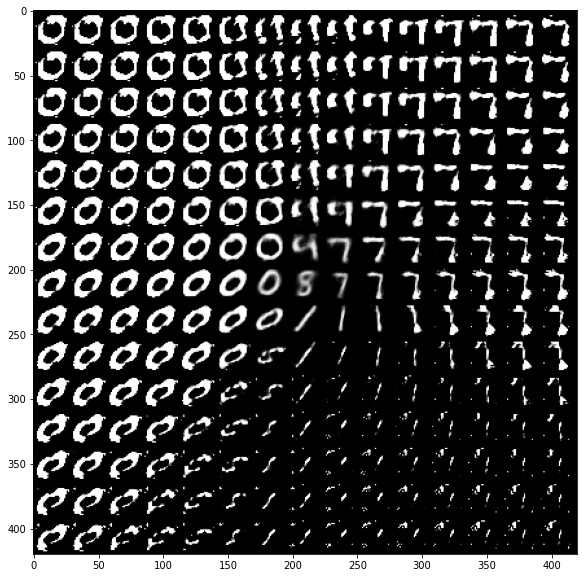

In [40]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()